#Objetivo

Realizar análise descritiva e construir modelo de predição de carteira de crédito.

**O que foi realizado?**

Importação limpeza dos dados, análise descritiva, modelo Catboost para avaliar relações entre valor_principal e demais variáveis da base. Por fim, modelo VAR série temporal de predição de contratações de crédito. 

#Limitações

**Qual problema foi identificado?**

Foram identificados alguns problemas na base. Não foi possível calcular a "carteira de crédito" por limitações da base, que apresenta apenas contratações, e não o saldo ao longo do tempo (que varia de acordo com antecipações, pagamentos de parcela e atrasos por exemplo).

A partir disso, foi projetada novas contratações, e não a carteira de crédito.

#Pacotes

Importação de pacotes necessários.

In [0]:
pip install catboost imbalanced-learn pyspark_dist_explore geopandas shap numpy_financial

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 78.3 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import re
import json

#finance
import numpy_financial as npf


#grafico
import matplotlib.pyplot as plt
import shap

#Machine Learning/estatistica
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

#Pyspark
from pyspark.sql.types import StringType
from pyspark.sql.functions import col as C, pandas_udf, udf
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W
from pyspark.sql.types import DecimalType
from decimal import Decimal

#datetime
from datetime import datetime,timedelta,date
from dateutil.relativedelta import relativedelta

In [0]:
#MaxPartittions
spark.conf.set("spark.databricks.queryWatchdog.maxHivePartitions", 32000)

#Dados

Importar dados necessários.

In [0]:
dados_operacoes = (spark.read.csv("/Volumes/prd/ailos_crm/team/dados_operacoes.csv", header=True, inferSchema=True)
.select(
 'id',
 'data_operacao',
 (F.months_between(C("data_operacao").cast("date"), C("nascimento").cast("date")) / 12).cast("int").alias('idade'),
 'genero',
 'bairro',
 'cidade',
 'estado',
 'ocupacao',
 'empregador',
 'operacao',
 C('valor_principal').cast(DecimalType(10, 2)),
 C('parcelas').cast('int'),
 C('parcelas_pagas').cast('int'),
 F.when(F.months_between(F.lit('2022-12-30'),C("data_operacao").cast("date")  ) <= C('parcelas'),F.months_between(F.lit('2022-12-30'),C("data_operacao").cast("date")  ) ).otherwise(C('parcelas')) .cast("int").alias('parcela_atual'),
 C('taxa_contrato').cast(DecimalType(10, 5)),
 C('valor_parcela').cast('int'),
 C('valor_bruto').cast('int') )
 .select('*', (F.when(C('parcela_atual') > (C('parcelas_pagas')+F.lit(3)), 1).otherwise(0)).alias('inadimplencia'))
 )

In [0]:
dados_operacoes.display()

id data_operacao idade genero bairro cidade estado ocupacao empregador operacao valor_principal parcelas parcelas_pagas parcela_atual taxa_contrato valor_parcela valor_bruto inadimplencia 682e8b505c30bb12052f9457516dc47e7eafc8ed 2019-09-13 45 F Conjunto Paulo Vi Moreira Rio de Janeiro Espeleologista e53d5342e82e0ce6061bc3aaea1a986f24a73613 Prod 27810.69 100 20 39 1.46493 531 53156 1 45ad9d444a276407df8b6f47c0fcc5b127dadaaa 2022-11-03 34 F Minas Caixa da Mota de Azevedo Amapá Mágico f715ffaf2c8294df43df3357c6a37f04b900fb06 Refin 9589.96 40 6 1 4.53587 523 20952 0 81cec74ea2ca41535fee03daeb410ddbdf12906a 2021-06-13 45 Null Vila Mantiqueira Rocha da Prata Santa Catarina Null da9515ffa45dd12791be0941b91188e51fe1cc04 Prod 42963.20 100 10 18 1.44749 815 81571 1 4e987d9178e2dcb07c2bf3878736233a676a0a87 2021-08-30 39 F Anchieta da Mata Null Conferente de carga e descarga 0c1741dc26339e6af3e4b6badcf984d383d1ca44 Port + Refin 2954.14 120 6 16 1.82904 60 7315 1 595943ecdb32a24ccb6ef374b6d865f3b60d7130 2022-11-16 37 F Conjunto Floramar Moreira de Goiás Mato Grosso Treinador f97b240dc24290c19e717d7a654747aa31722ad3 Prod 31186.17 100 10 1 3.28340 1066 106611 0 5e45a621fbb7998f7588091f8b7d480d3b24b2fc 2020-11-02 36 M Vila Fumec Campos Roraima Cirurgião bucal Null Port + Refin 41432.39 40 8 25 0.70787 1193 47720 1 a31aba3a584cedd544a31cfe3af96a0dc06bad17 2019-11-22 22 M Null Null Pernambuco Produtor de audio visual 25474923a0bac6ed841e0b776b035c73c444da1f Prod 16870.66 60 9 37 1.13080 388 23328 1 b0798e02f03eb1ad4ef5a8cbbc69e2732a7052d0 2021-12-08 24 F Vila Da Ária Araújo Alagoas Velejador 8e9e183c401487c93eb9c9127d15e0908208d252 Refin 2832.39 80 12 12 2.67154 86 6889 0 1676c0f980840a4fb7d808fc831412e8cc0c1b29 2022-08-18 38 M Vila Tirol Campos Alagoas Soldado ecfeed45ad3c07bc0533b71937ff3fb0be094a12 Prod 22710.72 40 10 4 3.64272 1087 43486 0 3411c0726cfae279d32d3a6a1d1c8a8fc560ffd5 2019-12-04 20 M Nossa Senhora Do Rosário Fogaça Ceará Null 8032e14ec79691c862249d17e0050d7da49913b9 Prod 18878.32 40 0 36 0.99986 574 22997 1 4b675483e6a8b4cedf83c6b7a6dd92b4a614cc6b 2020-06-05 47 M Gameleira Null São Paulo Designer de jóia e6b30eaf174237aff07da4bc854939a0aa1520d2 Prod 33062.05 60 15 30 1.20619 777 46647 1 fa2bf908dc14228e74506d4b7ada39da4a6e5344 2022-01-18 34 F Das Industrias I Dias Verde Null Profissional de comércio exterior 001e20a46054d36636785081fbdbbe3075c8bf11 Refin 15106.76 40 22 11 3.24027 679 27167 0 03ab321d457a96d5f46393f447a6623eabe6f6de 2019-10-20 42 Null Independência Lopes Roraima Agrimensor 818e471716236f5ae1287deb965387660ddcaa61 Prod 25841.26 60 33 38 2.11005 763 45800 1 49e18fde7076621170dc3a12ead65a8604ca27d3 2019-04-17 23 M Boa Vista Null Bahia Político 2a2bd62e98293ecb458bd3247e7340c63db574f6 Refin 7912.13 90 13 44 2.63349 230 20753 1 b263c36a2c1741e8642919ddfe26dd17c3ba3984 2020-09-11 29 F Grajaú Santos Tocantins Agente comunitário de saúde 3301937afea82ebafe8e1a45ef0846b0efb0128b Prod 22125.40 40 6 27 0.61798 626 25040 1 7cf9ebe6f665728bb3bb82694b81d8d266125585 2022-01-07 26 F Lagoinha Barbosa do Amparo Paraná Modelista 59af5fb42aa337439dab9df5459c664adcd713c8 Prod 31412.49 40 6 11 2.31083 1211 48472 1 48f5091cb053e57a80ae942ba1f1b7ec6ce10362 2021-10-23 41 F Apolonia Martins do Galho Pará Null 5ef3c2b6da6255b819e07084a3f81b63732d8efa Prod 27671.21 40 10 14 2.21377 1049 41994 1 2e01218ec5e6fc02cd9858bf257452ef574233d7 2022-03-11 43 Null Conjunto Minas Caixa Rocha Grande Null Null cc00064e54ff7e7de97e126fa63e25fb63879579 Port + Refin 30068.30 40 6 9 2.47270 1192 47692 0 b7183d457a16d62473ee3cf223c4b89469e9820d 2022-08-18 47 M Cidade Nova Cardoso da Praia Acre Bedel da3fbcf60f3378b244bfdae43c47e3166558919d Prod 34374.54 60 12 4 4.96679 1805 108350 0 d98a52f5f5e52b78c44ae3b12f16600d084b4b6f 2019-03-10 19 F Vila Ecológica Pereira Sergipe Naturólogo 3301937afea82ebafe8e1a45ef0846b0efb0128b Prod 41011.97 40 4 40 1.24404 1307 52308 1 0b069b999a6f173cdbcb79e1072864206c2b7018 2021-07-15 33 F Andiroba Cunha Acre Jogador de handebol 3

#Análise descritiva

Utilização de estatística descritiva para entender dados.

In [0]:
#estatísticas descritivas
resumo = dados_operacoes.describe().display()

summary id idade genero bairro cidade estado ocupacao empregador operacao valor_principal parcelas parcelas_pagas parcela_atual taxa_contrato valor_parcela valor_bruto inadimplencia count 14895 14895 14895 14895 14895 14895 14895 14895 14895 14895 14895 14895 14895 14895 14895 14895 14895 mean null 34.553608593487745 null null null null null null null 23185.875466 68.22423632091306 15.739039946290701 20.732661967103056 2.134700912 723.7716012084592 47446.19395770393 0.5648875461564283 stddev null 9.392594071278394 null null null null null null null 13500.843754250112 27.12826444907251 17.519803386272685 13.49357271554069 1.3411723408175 515.0751446718643 39877.21582865303 0.4957883711281177 min 000c6067c4dd520edbb54c7cdc9eac485b78c738 17 F Aarão Reis Almeida Acre Acompanhante 00194f6ab533d301934669fe9d7545aac08ac361 Port + Refin 203.55 40 0 0 0.34737 3 252 0 max ffe50c41b23d7e64c97eca21fab29f431e6346f8 52 Null Ápia das Neves dos Dourados Tocantins Árbitro e mediador ffdadd12039f125d20ed82648dfc90c5e283f54a Refin 49995.02 120 108 47 6.46168 3063 367678 1

In [0]:
#media valor crédito
colunas_lista = ['genero','estado','ocupacao','operacao']
for coluna in colunas_lista:
    df_col_group = dados_operacoes.groupBy(coluna).agg(F.mean('inadimplencia').cast('float').alias('Média'),
                                                       F.median('inadimplencia').cast('int').alias('Mediana'),
                                                       F.count('inadimplencia').cast('int').alias('count'),
                                                       )
    df_col_group.show()

+------+----------+-------+-----+
|genero|     Média|Mediana|count|
+------+----------+-------+-----+
|     F|  0.568138|      1| 8813|
|     M| 0.5616975|      1| 4595|
|  Null|0.55548084|      1| 1487|
+------+----------+-------+-----+

+-------------------+----------+-------+-----+
|             estado|     Média|Mediana|count|
+-------------------+----------+-------+-----+
|     Santa Catarina|0.55990785|      1|  434|
| Mato Grosso do Sul|0.54545456|      1|  429|
|              Goiás| 0.5548523|      1|  474|
|        Mato Grosso|0.58315337|      1|  463|
|              Ceará|0.55193484|      1|  491|
|              Piauí| 0.5567227|      1|  476|
|     Espírito Santo|0.57172555|      1|  481|
|             Paraná|0.57298476|      1|  459|
|            Alagoas|0.55578095|      1|  493|
|              Bahia| 0.5827957|      1|  465|
|            Roraima|0.56828195|      1|  454|
|   Distrito Federal|0.54120266|      1|  449|
|         Pernambuco| 0.5589431|      1|  492|
|        

In [0]:
#media valor crédito
colunas_lista = ['genero','estado','ocupacao','operacao']
for coluna in colunas_lista:
    df_col_group = dados_operacoes.groupBy(coluna).agg(F.mean('valor_principal').cast('int').alias('Média'),
                                                       F.median('valor_principal').cast('int').alias('Mediana'))
    df_col_group.show()

+------+-----+-------+
|genero|Média|Mediana|
+------+-----+-------+
|     F|23271|  20319|
|     M|23087|  20081|
|  Null|22986|  20346|
+------+-----+-------+

+-------------------+-----+-------+
|             estado|Média|Mediana|
+-------------------+-----+-------+
|     Santa Catarina|24170|  21629|
| Mato Grosso do Sul|23847|  22150|
|              Goiás|23361|  20479|
|        Mato Grosso|22172|  19603|
|              Ceará|22601|  19389|
|              Piauí|22135|  18988|
|     Espírito Santo|23314|  20721|
|             Paraná|22479|  19204|
|            Alagoas|22955|  20225|
|              Bahia|23892|  21353|
|            Roraima|23452|  20991|
|   Distrito Federal|22958|  19795|
|         Pernambuco|23639|  21954|
|           Amazonas|22524|  19267|
|               Acre|22437|  19338|
|  Rio Grande do Sul|23383|  19912|
|Rio Grande do Norte|23906|  21415|
|            Sergipe|22765|  20155|
|          São Paulo|23377|  20117|
|     Rio de Janeiro|24142|  21838|
+---------

In [0]:
#media taxa
for coluna in colunas_lista:
    df_col_group = dados_operacoes.groupBy(coluna).agg(F.mean('taxa_contrato').cast('int').alias('Média'),
                                                       F.median('taxa_contrato').cast('int').alias('Mediana'))
    df_col_group.show()

+------+-----+-------+
|genero|Média|Mediana|
+------+-----+-------+
|     F|    2|      1|
|     M|    2|      1|
|  Null|    2|      1|
+------+-----+-------+

+-------------------+-----+-------+
|             estado|Média|Mediana|
+-------------------+-----+-------+
|     Santa Catarina|    2|      1|
| Mato Grosso do Sul|    2|      1|
|              Goiás|    2|      1|
|        Mato Grosso|    2|      1|
|              Ceará|    2|      1|
|              Piauí|    2|      1|
|     Espírito Santo|    2|      1|
|             Paraná|    2|      1|
|            Alagoas|    2|      1|
|              Bahia|    2|      1|
|            Roraima|    2|      1|
|   Distrito Federal|    2|      1|
|         Pernambuco|    2|      1|
|           Amazonas|    2|      1|
|               Acre|    2|      1|
|  Rio Grande do Sul|    2|      1|
|Rio Grande do Norte|    2|      1|
|            Sergipe|    2|      1|
|          São Paulo|    2|      1|
|     Rio de Janeiro|    2|      1|
+---------

In [0]:
#transformar para pandas, para facilitar algumas analises (dado o tamanho do df, nao teremos problemas)
dados_operacoes_pd = dados_operacoes.toPandas().replace('Null', np.nan)
dados_operacoes_pd['taxa_contrato'] = dados_operacoes_pd['taxa_contrato'].astype(float)
dados_operacoes_pd['valor_principal'] = dados_operacoes_pd['valor_principal'].astype(float)

In [0]:
#Contagem de Nulos
dados_operacoes_pd.isna().sum()

id                    0
data_operacao         0
idade                 0
genero             1487
bairro             2539
cidade             2831
estado             2234
ocupacao           2271
empregador         3124
operacao              0
valor_principal       0
parcelas              0
parcelas_pagas        0
parcela_atual         0
taxa_contrato         0
valor_parcela         0
valor_bruto           0
inadimplencia         0
dtype: int64

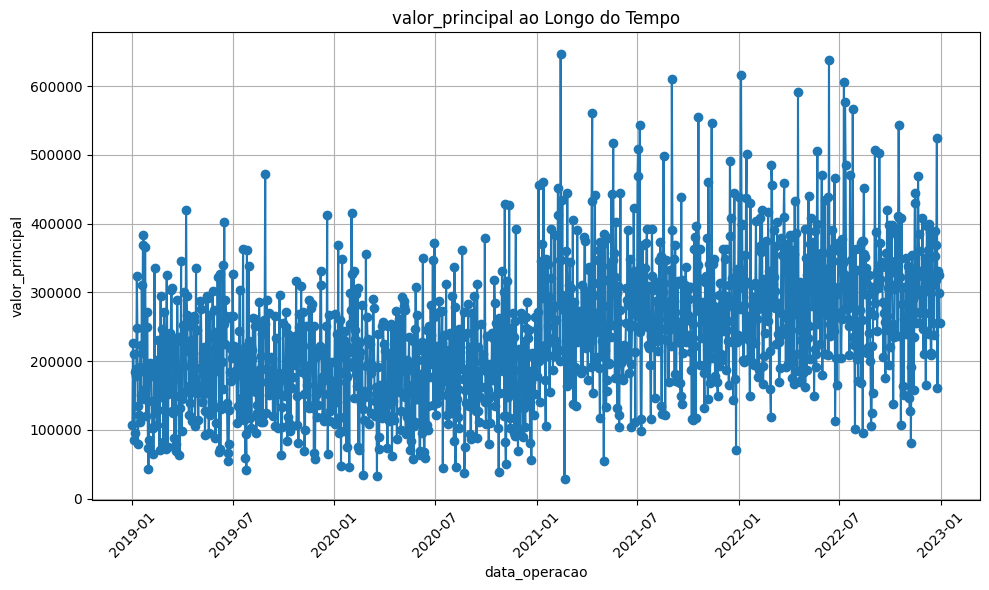

In [0]:
#Converter a coluna "data" para o tipo datetime, se necessário
df_agrupado = dados_operacoes_pd.groupby('data_operacao')['valor_principal'].sum().reset_index()
df_agrupado['data_operacao'] = pd.to_datetime(df_agrupado['data_operacao'])
df_agrupado = df_agrupado.sort_values(by='data_operacao')

#Criar o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(df_agrupado['data_operacao'], df_agrupado['valor_principal'], marker='o', linestyle='-')
plt.xlabel('data_operacao')
plt.ylabel('valor_principal')
plt.title('valor_principal ao Longo do Tempo')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

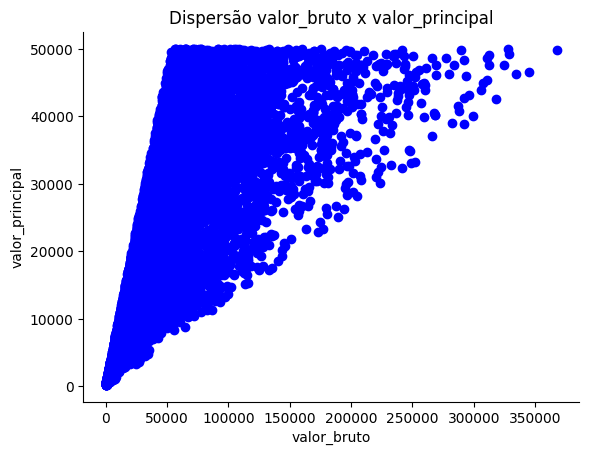

In [0]:
#Gráfico de dispersão entre taxa e valor (nao há relacao linear)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(dados_operacoes_pd['valor_bruto'], dados_operacoes_pd['valor_principal'],color='blue')
plt.xlabel('valor_bruto')
plt.ylabel('valor_principal')
plt.title('Dispersão valor_bruto x valor_principal')
plt.show()

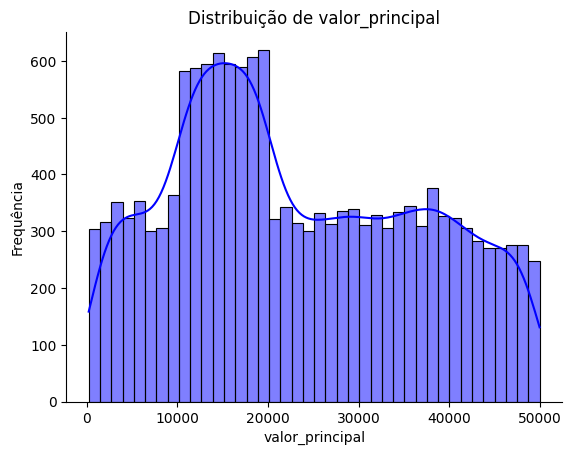

In [0]:
#gráfico de distribuição valor_principal
sns.histplot(dados_operacoes_pd['valor_principal'], kde=True, color='blue',bins=40)
sns.despine()
plt.xlabel('valor_principal')
plt.ylabel('Frequência')
plt.title('Distribuição de valor_principal')
plt.show()

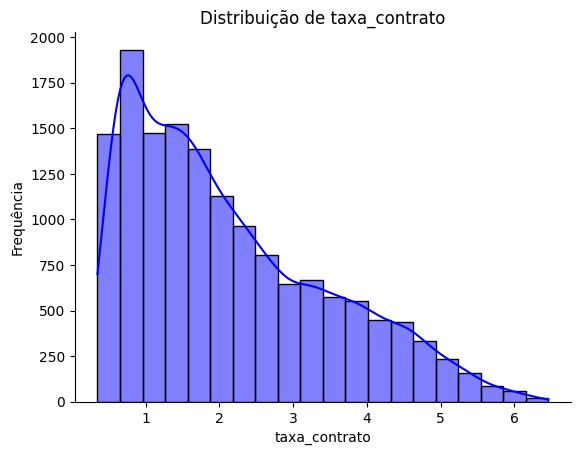

In [0]:
#gráfico de distribuição taxa_contrato
sns.histplot(dados_operacoes_pd['taxa_contrato'], kde=True, color='blue',bins=20)
sns.despine()
plt.xlabel('taxa_contrato')
plt.ylabel('Frequência')
plt.title('Distribuição de taxa_contrato')
plt.show()

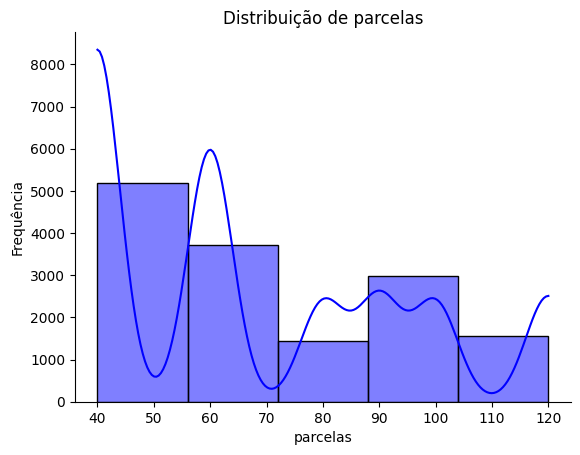

In [0]:
#gráfico de distribuição parcelas
sns.histplot(dados_operacoes_pd['parcelas'], kde=True, color='blue',bins=5)
sns.despine()
plt.xlabel('parcelas')
plt.ylabel('Frequência')
plt.title('Distribuição de parcelas')
plt.show()

In [0]:
#Calcular correlação pearson para colunas numericas
df_pearson = dados_operacoes_pd.select_dtypes(include=['int', 'float'])
correlacoes = df_pearson.corr()['taxa_contrato']
correlacoes = correlacoes.drop('taxa_contrato')
correlacoes = correlacoes.abs().sort_values(ascending=False)
print(correlacoes)

parcela_atual      0.606646
inadimplencia      0.585572
valor_bruto        0.518016
valor_parcela      0.433439
parcelas           0.182425
idade              0.077473
parcelas_pagas     0.056280
valor_principal    0.009728
Name: taxa_contrato, dtype: float64


In [0]:
#Calcular correlação pearson para colunas numericas
df_pearson = dados_operacoes_pd.select_dtypes(include=['int', 'float'])
correlacoes = df_pearson.corr()['valor_principal']
correlacoes = correlacoes.drop('valor_principal')
correlacoes = correlacoes.abs().sort_values(ascending=False)
print(correlacoes)

valor_parcela     0.821375
valor_bruto       0.695783
parcelas_pagas    0.017291
inadimplencia     0.013587
idade             0.010995
taxa_contrato     0.009728
parcelas          0.007953
parcela_atual     0.006801
Name: valor_principal, dtype: float64


In [0]:
#avaliar relacao entre variaveis texto e valor_principal ANOVA
for coluna in colunas_lista:
    resultado_anova = f_oneway(*[grupo['valor_principal'] for nome_grupo, grupo in dados_operacoes_pd.groupby(coluna)])
    p_valor = resultado_anova.pvalue
    print(coluna)
    print("P-valor:", round(p_valor,2))

genero
P-valor: 0.45
estado
P-valor: 0.44
ocupacao
P-valor: 0.57
operacao
P-valor: 0.0


In [0]:
#avaliar relacao entre variaveis texto e taxa_contrato ANOVA
for coluna in colunas_lista:
    resultado_anova = f_oneway(*[grupo['taxa_contrato'] for nome_grupo, grupo in dados_operacoes_pd.groupby(coluna)])
    p_valor = resultado_anova.pvalue
    print(coluna)
    print("P-valor:", round(p_valor,2))

genero
P-valor: 0.46
estado
P-valor: 0.02
ocupacao
P-valor: 0.86
operacao
P-valor: 0.96


In [0]:
#Chi-Quadrado
for i in range(len(colunas_lista)):
    for j in range(i + 1, len(colunas_lista)):
      coluna1 = colunas_lista[i]
      coluna2 = colunas_lista[j]

      #Criar tabela de contingência
      contingency_table = pd.crosstab(dados_operacoes_pd[coluna1], dados_operacoes_pd[coluna2])

      #Aplicar o teste de Chi-Quadrado
      chi2, p_valor, liberdade, expected = chi2_contingency(contingency_table)
      print(f"Teste de Chi-Quadrado entre {coluna1} e {coluna2}:")
      print("P-valor:", round(p_valor, 2))

Teste de Chi-Quadrado entre genero e estado:
P-valor: 0.0
Teste de Chi-Quadrado entre genero e ocupacao:
P-valor: 0.0
Teste de Chi-Quadrado entre genero e operacao:
P-valor: 0.51
Teste de Chi-Quadrado entre estado e ocupacao:
P-valor: 0.0
Teste de Chi-Quadrado entre estado e operacao:
P-valor: 0.24
Teste de Chi-Quadrado entre ocupacao e operacao:
P-valor: 0.39


In [0]:
#o estado como significativo em taxa, chamou atenção. vamos avaliar melhor esse comportamento avaliando regioes/estados
uf = dados_operacoes_pd.groupby('estado')['taxa_contrato'].mean().sort_values(ascending=False)
uf = uf.reset_index(name='taxa_contrato')
display(uf)

estado taxa_contrato Rio de Janeiro 2.2955484231536927 Maranhão 2.260197705735661 Paraíba 2.247654713375796 Rondônia 2.246744270386266 Rio Grande do Norte 2.2425172043010755 Alagoas 2.233767586206896 Mato Grosso do Sul 2.231976013986014 Santa Catarina 2.200816382488479 Ceará 2.1843085539714866 Sergipe 2.1833163312368975 Rio Grande do Sul 2.170137213438735 Amazonas 2.1610544626168227 Tocantins 2.1449017169373548 Piauí 2.1359848529411765 Acre 2.1258361328125 Distrito Federal 2.12409714922049 Bahia 2.121883612903226 Paraná 2.1190070806100216 São Paulo 2.1106478028747433 Pernambuco 2.0845725203252035 Goiás 2.083646054852321 Minas Gerais 2.0793691507431 Espírito Santo 2.0752124948024946 Mato Grosso 2.047551857451404 Amapá 2.034073455284553 Pará 2.0243621298174443 Roraima 2.008847004405286

<Figure size 640x480 with 0 Axes>

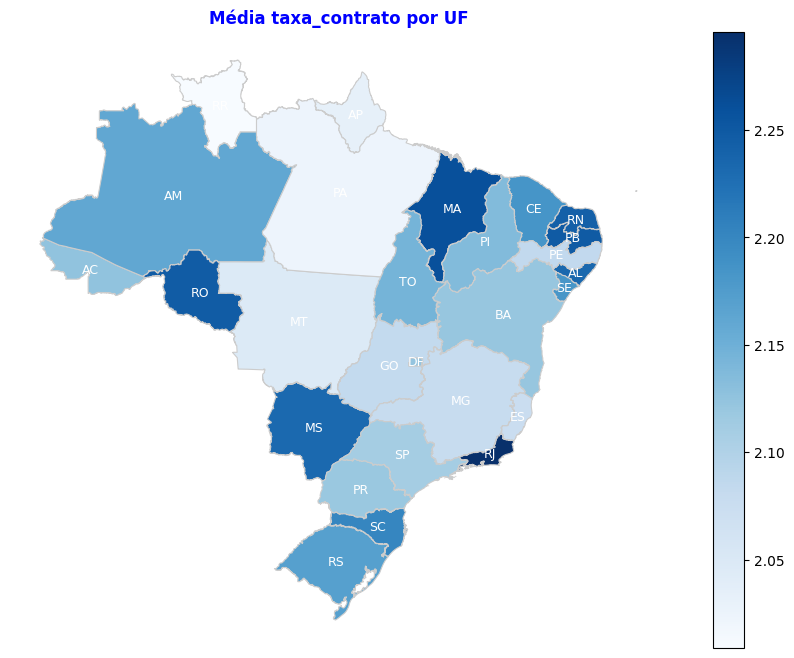

In [0]:
caminho_arquivo_json = "/Volumes/prd/ailos_crm/team/estados.json"
#https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson

#importar json
with open(caminho_arquivo_json, 'r') as arquivo_json:
    dados_json = json.load(arquivo_json)

#GeoDataFrame a partir do GeoJSON
gdf_states = gpd.GeoDataFrame.from_features(dados_json['features'])

#mesclar os dados com as geometrias dos estados
gdf = gdf_states.merge(uf, left_on='name', right_on='estado')

#grafico
plt.clf()
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(column='taxa_contrato', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
for x, y, label,over30_mean in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['sigla'],gdf['taxa_contrato']):
    font_color = 'white' if over30_mean > 1.55 else 'black'
    ax.text(x, y, label, fontsize=9, ha='center', va='center',color=font_color)

#bordas
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
#titulo
plt.title('Média taxa_contrato por UF',color='blue', weight='bold')
plt.show()

#CatBoost/Shap

Aplicação de modelo CatBoost com o objetivo apenas exploratório, de verificar as variáveis mais importantes para prever "valor_principal"

In [0]:
df_catboot = dados_operacoes_pd.dropna()
#Separar as variaveis x e y
X = df_catboot.drop(columns=['valor_principal','id','data_operacao'])
y = df_catboot['valor_principal']

#lista de colunas categoricas
colunas_cat = df_catboot.drop(columns=['valor_principal','id','data_operacao']).select_dtypes(include=['object']).columns.tolist()
#separar em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#separar em conjunto de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
#model parametros
model = CatBoostRegressor(iterations=200, depth=8, cat_features=colunas_cat,random_state=42, verbose=False)
#Treinar o modelo
model.fit(X_train, y_train,eval_set=(X_val, y_val))

In [0]:
#Fazer previsões no conjunto de teste
previsoes = model.predict(X_test)
mse = mean_absolute_error(y_test, previsoes)
rmse = mean_squared_error(y_test, previsoes,squared=False)
r2 = r2_score(y_test, previsoes)
print("R2 score:", round(r2,4))
print("MSE:", round(mse,1))
print("RMSE:", round(rmse,1))

R2 score: 0.9969
MSE: 527.1
RMSE: 731.7


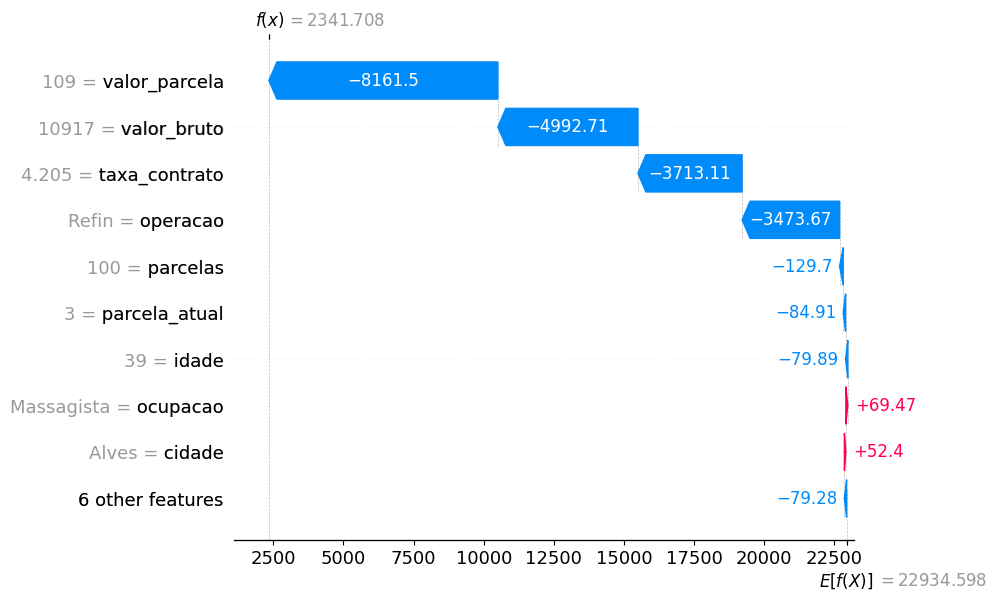

In [0]:
#JavaScript necessária
shap.initjs()
#dados shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)
#grafico
shap.plots.waterfall(shap_values[2])

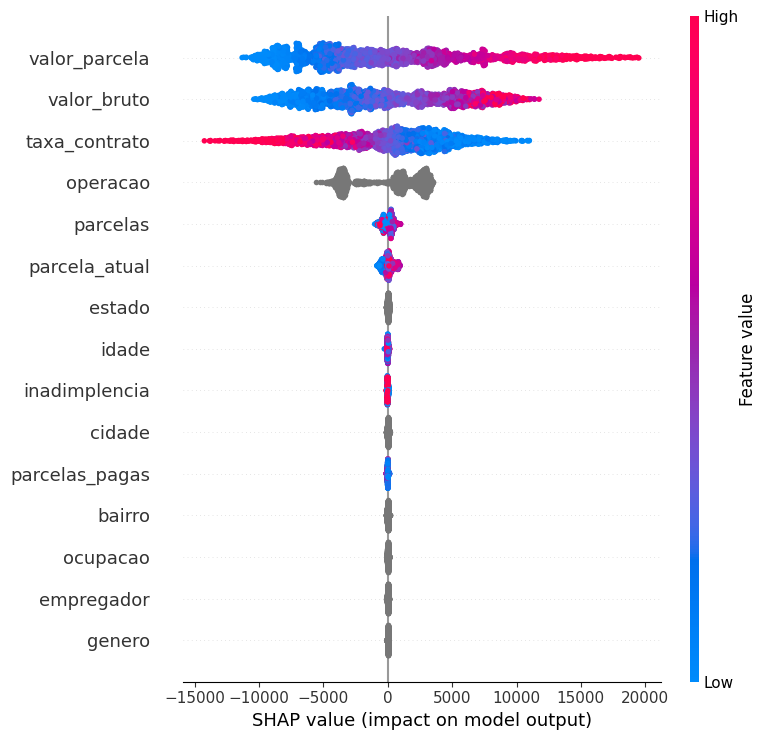

In [0]:
#grafico
shap.summary_plot(shap_values, X_train)

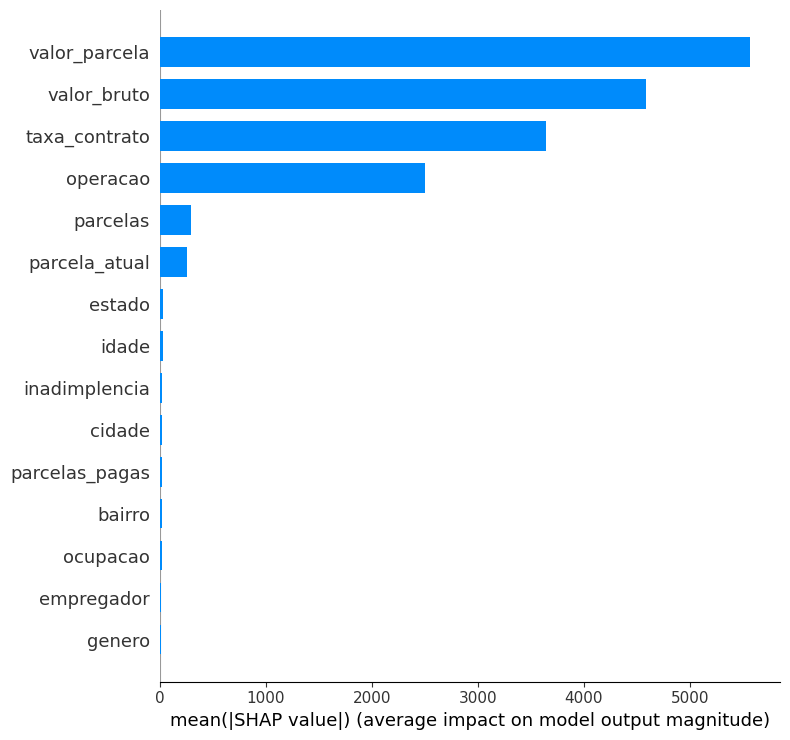

In [0]:
#Gráfico de resumo
shap.summary_plot(shap_values, X_train, plot_type="bar")

#Série temporal


In [0]:
#datas
datas = pd.date_range(start='2019-01-01', end='2022-12-30', freq='D')
df_datas = pd.DataFrame({'data_operacao': datas})
df_datas['dia_da_semana'] = df_datas['data_operacao'].dt.dayofweek
df_datas['dia_do_mes'] = df_datas['data_operacao'].dt.day

#resumo
df_resumo_operacoes = (dados_operacoes_pd.groupby('data_operacao').agg(
valor_principal=('valor_principal', 'sum'),
valor_principal_mean=('valor_principal', 'mean'),
valor_principal_median=('valor_principal', 'median'),
valor_bruto_sum=('valor_bruto', 'sum'),
valor_bruto_mean=('valor_bruto', 'mean'),
valor_bruto_median=('valor_bruto', 'median'),
taxa_contrato_sum=('taxa_contrato', 'sum'),
taxa_contrato_mean=('taxa_contrato', 'mean'),
taxa_contrato_median=('taxa_contrato', 'median')
).reset_index()
)
df_resumo_operacoes['data_operacao'] = pd.to_datetime(df_resumo_operacoes['data_operacao'])

#df_final
df_serie = df_resumo_operacoes.merge(df_datas, on='data_operacao', how='inner').fillna(0)
df_serie.set_index('data_operacao', inplace=True)

In [0]:
df_serie

valor_principal  valor_principal_mean  ...  dia_da_semana  dia_do_mes
data_operacao                                         ...                           
2019-01-01           107663.77          17943.961667  ...              1           1
2019-01-02           226089.48          22608.948000  ...              2           2
2019-01-03           210935.84          17577.986667  ...              3           3
2019-01-04            85949.57          12278.510000  ...              4           4
2019-01-05            95787.24          15964.540000  ...              5           5
...                        ...                   ...  ...            ...         ...
2022-12-26           160835.74          20104.467500  ...              0          26
2022-12-27           331690.99          20730.686875  ...              1          27
2022-12-28           299305.49          27209.590000  ...              2          28
2022-12-29           325785.43          20361.589375  ...              3          29
2022-12-30           254971.48          28330.164444  ...              4          30

[1457 rows x 11 columns]

In [0]:
#cria funcao para tratamento
def CalculaEstatisticas(df, coluna):

     #ultimo
    df['Last'+coluna] = df[coluna].transform(lambda x: x.shift().rolling(1, min_periods=1).mean()).round(2)
    
    #media movel30
    df['AvgMov30'+coluna] = df[coluna].transform(lambda x: x.shift().rolling(30, min_periods=1).mean()).round(2)

    #media movel60
    df['AvgMov60'+coluna] = df[coluna].transform(lambda x: x.shift().rolling(60, min_periods=1).mean()).round(2)

    #media movel120
    df['AvgMov120'+coluna] = df[coluna].transform(lambda x: x.shift().rolling(120, min_periods=1).mean()).round(2)

    #Substitui NaN nas colunas criadas pelo valor original da coluna 'coluna'
    for col in ['Last'+coluna,'AvgMov30'+coluna, 'AvgMov60'+coluna, 
                'AvgMov120'+coluna
                ]:
        df[col].fillna(df[coluna], inplace=True)


colunas_numericas = df_serie.select_dtypes(include=['float', 'int']).columns.tolist()

#for para criar estatisticas
for coluna in colunas_numericas:
    CalculaEstatisticas(df_serie, coluna)

In [0]:
#para listar nao estacionárias
list_diferenciacao = []

#estaciorariedade
for coluna in df_serie.columns:
    resultado_teste = adfuller(df_serie[coluna])
    p_valor = round(resultado_teste[1],2)
    print("----------",coluna,"-----------")
    print(f'p-valor: {p_valor}')
    if p_valor < 0.05:
        print("Estacionário")
    else:
        print("Não estacionário")
        list_diferenciacao.append(coluna)

# #diferenciacao
# for coluna in list_diferenciacao:
#     # Aplica a diferenciação à coluna atual
#     df_serie[coluna] = df_serie[coluna].diff()
# df_serie = df_serie[1:]

---------- valor_principal -----------
p-valor: 0.02
Estacionário
---------- valor_principal_mean -----------
p-valor: 0.0
Estacionário
---------- valor_principal_median -----------
p-valor: 0.0
Estacionário
---------- valor_bruto_sum -----------
p-valor: 0.91
Não estacionário
---------- valor_bruto_mean -----------
p-valor: 0.9
Não estacionário
---------- valor_bruto_median -----------
p-valor: 0.6
Não estacionário
---------- taxa_contrato_sum -----------
p-valor: 0.95
Não estacionário
---------- taxa_contrato_mean -----------
p-valor: 0.99
Não estacionário
---------- taxa_contrato_median -----------
p-valor: 0.99
Não estacionário
---------- dia_da_semana -----------
p-valor: 0.0
Estacionário
---------- dia_do_mes -----------
p-valor: 0.0
Estacionário
---------- Lastvalor_principal -----------
p-valor: 0.02
Estacionário
---------- AvgMov30valor_principal -----------
p-valor: 0.18
Não estacionário
---------- AvgMov60valor_principal -----------
p-valor: 0.22
Não estacionário
---------- 

In [0]:
#Colunas Log
colunas_numericas = df_resumo_operacoes.select_dtypes(include=['float', 'int']).columns.tolist()
novas_colunas_log = [f'{coluna}_log' for coluna in colunas_numericas]
df_serie = df_serie.assign(**{nova_coluna: np.log(df_serie[coluna]) for coluna, nova_coluna in zip(colunas_numericas, novas_colunas_log) if pd.api.types.is_numeric_dtype(df_serie[coluna])})

In [0]:
#Teste/treino
test_size = 180
train = df_serie[:-test_size]
test = df_serie[-test_size:]
#Treinando o modelo 
model = VAR(train)
model_fit = model.fit()
#Fazendo previsões teste
predictions = model_fit.forecast(train.values[-model_fit.k_ar:], steps=len(test))
predictions = [predictions[0] for predictions in predictions]
#avaliacao
mae = mean_absolute_error(test['valor_principal'], predictions)
print(mae)

79421.04657913386


/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [0]:
#Treinando o modelo 
modelo = VAR(df_serie)
resultado = modelo.fit()
range_dias = 730
#Fazendo previsões
previsoes = resultado.forecast(df_serie.values[-resultado.k_ar:], steps=range_dias)
#Criando um DataFrame apenas com as previsões para a variável "nps"
#Criar datas futuras previstas
datas = pd.date_range(start='2023-01-01', end='2024-12-30', freq='D')
df_previsao = pd.DataFrame({'data_operacao': datas})
df_previsao['data_operacao'] = df_previsao['data_operacao'].dt.date
df_previsao ['valor_principal'] = [round(previsao[0],2) for previsao in previsoes]

/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [0]:
df_previsao.display()

data_operacao valor_principal 2023-01-01 254655.16 2023-01-02 281439.01 2023-01-03 291336.63 2023-01-04 298584.79 2023-01-05 297312.15 2023-01-06 293190.14 2023-01-07 289145.35 2023-01-08 288832.11 2023-01-09 292098.51 2023-01-10 296143.11 2023-01-11 298000.09 2023-01-12 296618.43 2023-01-13 293359.19 2023-01-14 290724.57 2023-01-15 290366.88 2023-01-16 292037.32 2023-01-17 294048.3 2023-01-18 294690.88 2023-01-19 293473.4 2023-01-20 291305.34 2023-01-21 289644.19 2023-01-22 289371.67 2023-01-23 290244.0 2023-01-24 291229.56 2023-01-25 291365.09 2023-01-26 290439.88 2023-01-27 289040.48 2023-01-28 288015.49 2023-01-29 287828.2 2023-01-30 288278.77 2023-01-31 288743.1 2023-02-01 288682.55 2023-02-02 288019.22 2023-02-03 287126.08 2023-02-04 286494.16 2023-02-05 286362.37 2023-02-06 286581.59 2023-02-07 286777.23 2023-02-08 286650.81 2023-02-09 286183.5 2023-02-10 285609.54 2023-02-11 285211.32 2023-02-12 285109.16 2023-02-13 285197.8 2023-02-14 285254.12 2023-02-15 285114.31 2023-02-16 284783.05 2023-02-17 284405.83 2023-02-18 284144.02 2023-02-19 284056.34 2023-02-20 284071.15 2023-02-21 284056.47 2023-02-22 283923.42 2023-02-23 283683.8 2023-02-24 283427.12 2023-02-25 283244.94 2023-02-26 283164.62 2023-02-27 283138.7 2023-02-28 283089.61 2023-03-01 282969.7 2023-03-02 282791.1 2023-03-03 282608.37 2023-03-04 282473.08 2023-03-05 282397.06 2023-03-06 282349.47 2023-03-07 282285.03 2023-03-08 282178.54 2023-03-09 282040.07 2023-03-10 281902.6 2023-03-11 281794.92 2023-03-12 281721.48 2023-03-13 281662.58 2023-03-14 281591.91 2023-03-15 281496.39 2023-03-16 281383.57 2023-03-17 281273.24 2023-03-18 281181.32 2023-03-19 281108.95 2023-03-20 281043.7 2023-03-21 280970.4 2023-03-22 280882.37 2023-03-23 280784.99 2023-03-24 280690.01 2023-03-25 280606.17 2023-03-26 280533.27 2023-03-27 280463.55 2023-03-28 280388.31 2023-03-29 280304.26 2023-03-30 280215.05 2023-03-31 280127.62 2023-04-01 280046.71 2023-04-02 279971.7 2023-04-03 279897.8 2023-04-04 279820.06 2023-04-05 279736.91 2023-04-06 279650.77 2023-04-07 279565.72 2023-04-08 279484.3 2023-04-09 279405.84 2023-04-10 279327.44 2023-04-11 279246.28 2023-04-12 279161.67 2023-04-13 279075.18 2023-04-14 278989.19 2023-04-15 278905.05 2023-04-16 278822.2 2023-04-17 278738.89 2023-04-18 278653.53 2023-04-19 278565.86 2023-04-20 278476.88 2023-04-21 278387.99 2023-04-22 278299.87 2023-04-23 278212.12 2023-04-24 278123.69 2023-04-25 278033.7 2023-04-26 277942.07 2023-04-27 277849.45 2023-04-28 277756.64 2023-04-29 277664.01 2023-04-30 277571.26 2023-05-01 277477.78 2023-05-02 277383.08 2023-05-03 277287.18 2023-05-04 277190.48 2023-05-05 277093.45 2023-05-06 276996.27 2023-05-07 276898.76 2023-05-08 276800.55 2023-05-09 276701.38 2023-05-10 276601.31 2023-05-11 276500.58 2023-05-12 276399.46 2023-05-13 276298.06 2023-05-14 276196.24 2023-05-15 276093.81 2023-05-16 275990.64 2023-05-17 275886.77 2023-05-18 275782.35 2023-05-19 275677.56 2023-05-20 275572.44 2023-05-21 275466.93 2023-05-22 275360.89 2023-05-23 275254.28 2023-05-24 275147.13 2023-05-25 275039.55 2023-05-26 274931.63 2023-05-27 274823.4 2023-05-28 274714.82 2023-05-29 274605.82 2023-05-30 274496.38 2023-05-31 274386.54 2023-06-01 274276.35 2023-06-02 274165.89 2023-06-03 274055.15 2023-06-04 273944.13 2023-06-05 273832.79 2023-06-06 273721.12 2023-06-07 273609.14 2023-06-08 273496.91 2023-06-09 273384.45 2023-06-10 273271.78 2023-06-11 273158.89 2023-06-12 273045.76 2023-06-13 272932.39 2023-06-14 272818.8 2023-06-15 272705.02 2023-06-16 272591.08 2023-06-17 272476.97 2023-06-18 272362.7 2023-06-19 272248.26 2023-06-20 272133.65 2023-06-21 272018.9 2023-06-22 271904.0 2023-06-23 271788.99 2023-06-24 271673.87 2023-06-25 271558.64 2023-06-26 271443.29 2023-06-27 271327.83 2023-06-28 271212.27 2023-06-29 271096.63 2023-06-30 270980.91 2023-07-01 270865.12 2023-07-02 270749.26 2023-07-03 270633.33 2023-07-04 270517.33 2023-07-05 270401.27 2023-07-06 270285.17 2023-07-07 270169.03 2023-07-08 270052.84 2023-07-09 269936.62 2023